# Optimization Libraries

Mainly looking at them in context of hyper param tuning, but they are general libraries.

In [50]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
import xgboost as xgb

In [27]:
## Data

data = load_boston()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = data['target']

X

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [3]:
# Model we want to optimze

model = xgb.XGBRegressor()
model.fit(X, y)

scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
print(f' Avg. MSE: {scores.mean()*-1:0.4f} (+/- {scores.std():0.4f})')

 Avg. MSE: 19.4643 (+/- 11.5527)


In [5]:
## Hyperopt - Tree-Structured Parzen Estimation / Random Sampling

from hyperopt import fmin, hp, tpe, Trials, STATUS_OK

def objective(params):
    MAX_DEPTH = params['max_depth']
    N_ESTIMATORS = params['n_estimators']
    LAMBDA = params['lambda']
    ALPHA = params['alpha']
    
    model = xgb.XGBRegressor(
        max_depth=MAX_DEPTH,
        n_estimators=N_ESTIMATORS,
        reg_lambda=LAMBDA,
        reg_alpha=ALPHA,
        verbosity=0
    )
    model.fit(X, y)

    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
    mse = scores.mean()*-1

    return {
        'loss': mse,
        'status': STATUS_OK,
        'params': params
    }

search_space = {
    'max_depth': hp.randint('max_depth', 1, 100),  # Default = 6
    'n_estimators': hp.randint('n_estimators', 1, 500),  # Default = 100
    'lambda': hp.uniform('lambda', 0, 2),  # Default = 1
    'alpha': hp.uniform('alpha', 0, 4),  # Default = 0
}

trials = Trials()  # allows us to record info from each iteration
best = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=1000,
    trials=trials
)

print(best)
# {'alpha': 0.7196749905956826, 'lambda': 0.8726803031598735, 'max_depth': 3, 'n_estimators': 420}

100%|██████████| 1000/1000 [08:47<00:00,  1.89trial/s, best loss: 17.8259162028044] 
{'alpha': 0.7196749905956826, 'lambda': 0.8726803031598735, 'max_depth': 3, 'n_estimators': 420}


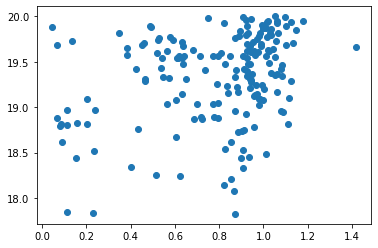

In [29]:
# Let's view Lambda (l2 reg)

x_chart = [x['result']['params']['lambda'] for x in trials.trials if x['result']['loss'] < 20]
y_chart = [x['result']['loss'] for x in trials.trials if x['result']['loss'] < 20]

plt.scatter(x_chart, y_chart)

In [56]:
## Evol - Genetic Approach

from evol import Population, Evolution

def population_start():
    """
    Init population with random starting conditions
    """
    max_depth = np.random.randint(low=1, high=100, size=None)
    n_estimators = np.random.randint(low=1, high=500, size=None)
    reg_lambda = np.random.uniform(low=0.0, high=2.0, size=None)
    reg_alpha = np.random.uniform(low=0.0, high=4.0, size=None)
    
    return max_depth, n_estimators, reg_lambda, reg_alpha

def objective(params):
    max_depth, n_estimators, reg_lambda, reg_alpha = params
    
    model = xgb.XGBRegressor(
        max_depth=max_depth,
        n_estimators=n_estimators,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        verbosity=0
    )
    model.fit(X, y)

    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
    mse = scores.mean()
    
    return mse


def pick_parents(pop):
    """
    Pick random parents
    """
    mom = np.random.choice(pop, None)
    dad = np.random.choice(pop, None)
    return mom, dad


def make_child(mom, dad):
    """
    This function describes how two candidates combine into a new candidate.
    
    We'll just take the average of two parents
    """
    child_max_depth = int(np.round((mom[0] + dad[0])/2))
    child_n_estimators = int(np.round((mom[1] + dad[1])/2))
    child_reg_lambda = (mom[2] + dad[2])/2
    child_reg_alpha = (mom[3] + dad[3])/2
    
    return child_max_depth, child_n_estimators, child_reg_lambda, child_reg_alpha

def add_noise(chromosome, sigma):
    """
    This is a function that will add some noise to the chromosome.
    """
    new_max_depth = chromosome[0] + np.random.choice([-1, 0, 1], None) * sigma
    new_n_estimators = chromosome[1] + np.random.choice([-1, 0, 1], None) * sigma
    new_reg_lambda = chromosome[2] + np.random.choice([-1, 0, 1], None) * (sigma/10)
    new_reg_alpha = chromosome[3] + np.random.choice([-1, 0, 1], None) * (sigma/10)
    
    # check if see if in bounds
    new_max_depth = int(new_max_depth) if new_max_depth >= 1 else 1
    new_n_estimators = int(new_n_estimators) if new_n_estimators >= 1 else 1
    new_reg_lambda = new_reg_lambda if new_reg_lambda >= 0 else 0
    new_reg_alpha = new_reg_alpha if new_reg_alpha >= 0 else 0
    
    return new_max_depth, new_n_estimators, new_reg_lambda, new_reg_alpha

# We start by defining a population with candidates.
pop = Population(
    chromosomes=[population_start() for _ in range(200)],
    eval_function=objective,
    maximize=True
)

evo = (
    Evolution()
    .survive(fraction=0.5)
    .breed(parent_picker=pick_parents, combiner=make_child)
    .mutate(add_noise, sigma=2)
    .evaluate()
)

for i in range(10):
    start = time.time()
    pop = pop.evolve(evo)
    end = time.time()
    delta = end - start
    print(f"iteration:{i+1} ({delta/60:0.2f}) best: {pop.current_best.fitness} worst: {pop.current_worst.fitness}")
    
print(pop.current_best.chromosome)

iteration:1 (3.38) best: -18.575845614541482 worst: -25.168145489770904
iteration:2 (1.75) best: -18.71881378624962 worst: -25.09893288403287
iteration:3 (1.65) best: -18.635818141362176 worst: -23.16358941811586
iteration:4 (1.64) best: -18.927997964148865 worst: -23.04058133639911
iteration:5 (1.66) best: -18.592041961306922 worst: -23.394284684343653
iteration:6 (1.68) best: -18.866826689782208 worst: -23.703412930119875


KeyboardInterrupt: 